In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import math

In [2]:
df = pd.read_csv('data/source/labels-with-tags-chu.csv')

In [3]:
#select city == seattle
df = df[df['city'] == 'seattle']
df

,city,label_id,label_type,severity,zoom,heading,pitch,photographer_heading,photographer_pitch,user_id,global_attribute_id,tag_list,description,lat,lng
0,seattle,161174,CurbRamp,1.0,1,317.000000,-16.250000,270.391571,-0.427856,8b57878d-8187-4c0a-b7f2-9a661d264985,NaN,missing tactile warning,NaN,47.665028,-122.313225
1,seattle,161176,CurbRamp,1.0,1,47.446430,-15.982142,1.767984,-0.627083,8b57878d-8187-4c0a-b7f2-9a661d264985,68677898.0,NaN,NaN,47.664982,-122.312920
2,seattle,188676,CurbRamp,1.0,1,221.437500,-35.000000,164.554047,0.114868,9a30e15b-c0bb-4e11-b801-bbab5da9c789,68708456.0,NaN,NaN,47.597446,-122.309044
3,seattle,161154,Obstacle,2.0,1,273.696442,-17.142857,78.104256,-5.573174,8b57878d-8187-4c0a-b7f2-9a661d264985,68679755.0,NaN,NaN,47.663170,-122.312782
4,seattle,161154,Obstacle,2.0,1,273.696442,-17.142857,78.104256,-5.573174,8b57878d-8187-4c0a-b7f2-9a661d264985,68680859.0,NaN,NaN,47.663170,-122.312782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266085,seattle,234196,NoSidewalk,4.0,1,332.750000,-18.875000,168.048965,0.996870,9d3db893-2f80-4dd4-85c3-43280cbc7a66,68727209.0,street has no sidewalks,NaN,47.692036,-122.367393
266086,seattle,234213,CurbRamp,1.0,1,266.812500,-25.000000,25.394808,-1.345330,9d3db893-2f80-4dd4-85c3-43280cbc7a66,68642579.0,NaN,NaN,47.677555,-122.279671
266087,seattle,234214,CurbRamp,1.0,1,266.812500,-25.000000,25.394808,-1.345330,9d3db893-2f80-4dd4-85c3-43280cbc7a66,68642572.0,NaN,NaN,47.677578,-122.279709
266088,seattle,234312,Signal,NaN,2,246.171875,-7.513393,88.950325,-0.363716,e4ff325c-309b-4ea6-8555-8f973e662362,68726853.0,NaN,NaN,47.686874,-122.366241


In [4]:
#get Nan counts of global attribute id
df['global_attribute_id'].isna().sum()

53640

In [5]:
#turn df into geodataframe
geometry = [Point(xy) for xy in zip(df.lng, df.lat)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [47]:
seattle = gdf.cx[-122.238 : -122.418, 47.734: 47.495]

In [7]:
len(seattle)

264599

<AxesSubplot: >

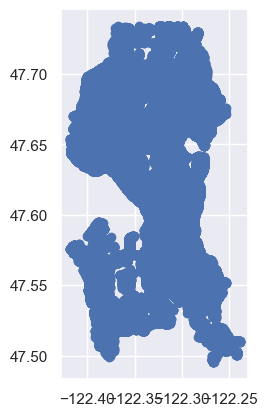

In [12]:
seattle.plot()

In [11]:
#seattle label id number of unique
seattle['label_id'].nunique()

202802

In [48]:
#select only label id taglist and description 
seattle = seattle[['label_id', 'tag_list', 'description']]



In [49]:
#select tag list that are not nan
seattle_tag = seattle.drop(columns=['description'])
seattle_tag = seattle_tag[seattle_tag['tag_list'].notna()]
# create a new column with the length of the tag list 
seattle_tag['tag_count'] = seattle_tag['tag_list'].str.split(',').str.len()
#drop tag_list column
seattle_tag = seattle_tag.drop(columns=['tag_list'])


In [50]:
#merge with seattle
seattle = seattle.merge(seattle_tag, on='label_id', how='left')

In [51]:
# #turn nan to 0 non nan to 1
seattle['tag_list'] = seattle['tag_list'].notna().astype('int')
seattle['description'] = seattle['description'].notna().astype('int')
#fill nan with 0
seattle = seattle.fillna(0)


In [52]:
#group by label id and max
seattle = seattle.groupby('label_id').max()
#reset index
seattle = seattle.reset_index()

<AxesSubplot: >

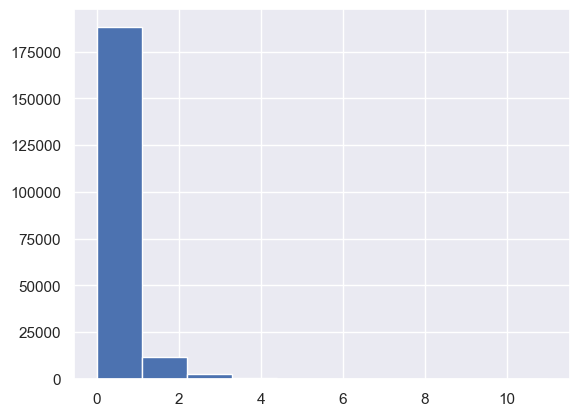

In [54]:
seattle['tag_count'].hist()

In [53]:
seattle

,label_id,tag_list,description,tag_count
0,9,1,0,1.0
1,10,1,0,1.0
2,11,0,0,0.0
3,12,1,0,1.0
4,13,0,0,0.0
...,...,...,...,...
202797,234360,0,0,0.0
202798,234361,0,0,0.0
202799,234362,0,0,0.0
202800,234363,0,0,0.0


In [58]:
#read in seattle
labels = pd.read_csv('data/processed-labels/seattle_labels_all.csv')

In [59]:
#create a new df with only label id from labels
label_ids = labels[['label_id']]
#merge label ids with seattle
seattle = pd.merge(label_ids, seattle, on='label_id', how='left')
#fill nan with 0
seattle = seattle.fillna(0).sort_values(by='label_id').reset_index(drop=True)
seattle

,label_id,tag_list,description,tag_count
0,9,1.0,0.0,1.0
1,10,1.0,0.0,1.0
2,11,0.0,0.0,0.0
3,12,1.0,0.0,1.0
4,13,0.0,0.0,0.0
...,...,...,...,...
195538,233233,1.0,0.0,1.0
195539,233234,1.0,0.0,1.0
195540,233235,1.0,0.0,2.0
195541,233236,0.0,0.0,0.0


In [60]:
#export to csv 
seattle.to_csv('data/features/optional_input.csv', index=False)